In [1]:
################################################
#Building segmentation prediction for each camp#
#Maintainer: Christopher Chan                  #
#Date: 2022-08-03                              #
#Version: 0.4.1                                #
################################################

import os, sys, re
import torch
import PIL
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp
import rasterio as rio
import torchvision.transforms.functional as func
from scipy import ndimage
from PIL import Image
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from Networks import Five_UNet, Four_UNet
from dataloader import PredictionDataset
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

print(f"Training on device {device}.")

# ATTENTION, DATASET USE IN THIS IS DIFFERENT FROM TRAIN, VAL, TEST
# THIS HAS NO OVERLAP IN CROPPING IN ORDER TO REPRESENT THE TRUE EXTENT
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/ALL_IMG_15cm")

Training on device cuda.


## Part 1: Calculate per camp building segmented pixel count

In [15]:
# Function to load trained weights to appropriate architecture to predict a certain camp

def loading(trained_weights, architecture, camp):
    IMG_ls = []

    if camp == "KBY":
        for root, dirs, filename in os.walk(os.path.join(data_path, "IMG")):
                for f in filename:
                    if (f.startswith("KBY15_IMG")) and (f.endswith(".png")):
                        IMG_ls.append(root + "/" + f)
                        
    elif camp == "DZK":
        for root, dirs, filename in os.walk(os.path.join(data_path, "IMG")):
                for f in filename:
                    if (f.startswith("DZK15_IMG")) and (f.endswith(".png")):
                        IMG_ls.append(root + "/" + f)
    
    elif camp == "DZKN":
        for root, dirs, filename in os.walk(os.path.join(data_path, "IMG")):
                for f in filename:
                    if (f.startswith("DZKN15_IMG")) and (f.endswith(".png")):
                        IMG_ls.append(root + "/" + f)
    
##############################################################

    # Load non-weighted architecture
    if architecture == "EB0-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b0', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
    
    elif architecture == "EB1-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None) 
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
    
        
       
    elif architecture == "qubvel":
        Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
        qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
        qubvel_weights = torch.load(qubvel_weights, map_location = device)
        Net.load_state_dict(qubvel_weights["state_dict"])
    
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)

    elif architecture == "EB2-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels= 3 , classes = 1, activation = "sigmoid", aux_params = None)
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
         
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
   
    elif architecture == "Four-Unet":
        Net = Four_UNet()
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
        
    elif architecture == "Five-Unet":
        Net = Five_UNet()
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
        
    print("Selected CNN architecture: {0} to predict camp {1}, which contains {2} images.".format(architecture, camp, len(IMG_ls)))
    
    # Load dataset and predict:
    test_ls = PredictionDataset(IMG_ls)
    loader = DataLoader(test_ls, batch_size = 1, shuffle = False)
    
    prediction_ls = []
    bool_ls = []
    pixcount_ls = []
    
    for i, img in tqdm(enumerate(loader), total = len(loader)):
        img = img.to(device = device)
        with torch.no_grad():
            prediction = Net(img)
            prediction = prediction.squeeze(0)
            prediction_ls.append(prediction)
    
            pred_BOOL = (prediction > 0.001).to(torch.float32)
    
            # Booleanise
            pred_BOOL = pred_BOOL.bool()
            bool_ls.append(pred_BOOL)

            pred_IO = pred_BOOL.long().cpu().numpy().squeeze(0)
            
            # List pixcount and img_ls to create new DF
            pixcount_ls.append((pred_IO == 1).sum())
            
            # Change from 16 bit to 8 bit so CV2 can read it
            #pred_IO_8bit = cv2.convertScaleAbs(pred_IO)
            
            # OPTION A: BlobDetector
            
           # Blob detection
            #params = cv2.SimpleBlobDetector_Params()

            # Change thresholds

            #params.minThreshold = 10
            #params.maxThreshold = 200
            ## Filter by Area.
            #params.filterByArea = True
            #params.minArea = 10
            #
            ## Filter by Convexity
            #params.filterByConvexity = True
            #params.minConvexity = 0.87
            ## Filter by Inertia
            #params.filterByInertia = True
            #params.minInertiaRatio = 0.01
            
            #detector = cv2.SimpleBlobDetector_create(params)
            #keypoints = detector.detect(pred_IO_8bit)
            #
            ## Draw detected blobs as red circles
            #blob_w_key = cv2.drawKeypoints(pred_IO_8bit, keypoints, 0, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            #plt.imshow(blob_w_key)
            #
            ## Show keypoints
            #cv2.waitKey(0)
            #
            #outline = cv2.polylines(blob_w_key, keypoints, isClosed = True, color = (0, 0, 255))
            #print(outline.shape)
            #
            #Blob_ls.append(outline)
           
    pixcount_dict = {
        "IMG": IMG_ls,
        "pix_count": pixcount_ls
    }
            
    pixcount_df = pd.DataFrame(pixcount_dict)
    
    for path in pixcount_df["IMG"]:
        pixcount_df["IMG"] = os.path.basename(path)
          
    return test_ls, prediction_ls, bool_ls, pixcount_df
     

Trainable parameters in current model: [864, 32, 32, 288, 32, 32, 256, 8, 256, 32, 512, 16, 16, 144, 16, 16, 64, 4, 64, 16, 256, 16, 16, 1536, 96, 96, 864, 96, 96, 384, 4, 384, 96, 2304, 24, 24, 3456, 144, 144, 1296, 144, 144, 864, 6, 864, 144, 3456, 24, 24, 3456, 144, 144, 1296, 144, 144, 864, 6, 864, 144, 3456, 24, 24, 3456, 144, 144, 3600, 144, 144, 864, 6, 864, 144, 6912, 48, 48, 13824, 288, 288, 7200, 288, 288, 3456, 12, 3456, 288, 13824, 48, 48, 13824, 288, 288, 7200, 288, 288, 3456, 12, 3456, 288, 13824, 48, 48, 13824, 288, 288, 2592, 288, 288, 3456, 12, 3456, 288, 25344, 88, 88, 46464, 528, 528, 4752, 528, 528, 11616, 22, 11616, 528, 46464, 88, 88, 46464, 528, 528, 4752, 528, 528, 11616, 22, 11616, 528, 46464, 88, 88, 46464, 528, 528, 4752, 528, 528, 11616, 22, 11616, 528, 46464, 88, 88, 46464, 528, 528, 13200, 528, 528, 11616, 22, 11616, 528, 63360, 120, 120, 86400, 720, 720, 18000, 720, 720, 21600, 30, 21600, 720, 86400, 120, 120, 86400, 720, 720, 18000, 720, 720, 21600, 30, 

100%|██████████| 1064/1064 [00:18<00:00, 57.62it/s]


Text(0.5, 1.0, 'Binary Segmentation')

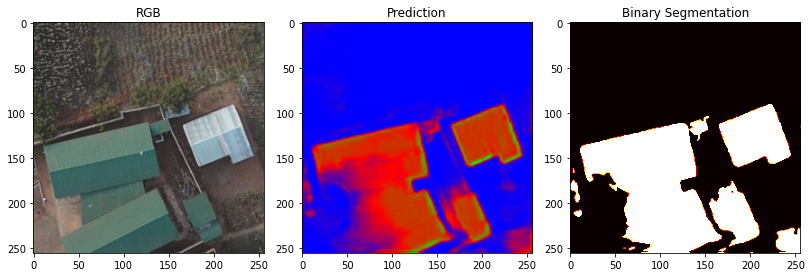

In [23]:
best_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/best_weights/BASE_15cmALL")

img_ls, prediction_ls, bool_ls, pixcount_df = loading(os.path.join(best_weights, "18242:3909_256oc_EB2-Unet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_286070.pth"),
                                                  "EB2-Unet", "DZK")

idx, sample = random.choice(list(enumerate(img_ls)))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
#fig.suptitle("256x256(15cm) {0} | {1}".format(camp, trained_weights))
RGB = sample.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(RGB)
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILpred = prediction_ls[idx].detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 3)
PILbin = bool_ls[idx].detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')


In [4]:
pixcount_df

,IMG,pix_count
0,DZK15_IMG_3328-1792.png,21339
1,DZK15_IMG_3328-1792.png,27327
2,DZK15_IMG_3328-1792.png,28535
3,DZK15_IMG_3328-1792.png,28476
4,DZK15_IMG_3328-1792.png,27202
...,...,...
1059,DZK15_IMG_3328-1792.png,20919
1060,DZK15_IMG_3328-1792.png,27374
1061,DZK15_IMG_3328-1792.png,25896
1062,DZK15_IMG_3328-1792.png,24456


In [5]:
print(pixcount_df["pix_count"].sum())

25796802


## Part 2: Calculate pixel count in label

In [6]:
def label_count(camp):

    LBL_ls = []
    LBL_pc = []

    if camp == "KBY":
        for root, dirs, filename in os.walk(os.path.join(data_path, "LBL")):
                for f in filename:
                    if (f.startswith("KBY15_LBL")) and (f.endswith(".png")):
                        LBL_ls.append(root + "/" + f)

    elif camp == "DZK":
        for root, dirs, filename in os.walk(os.path.join(data_path, "LBL")):
                for f in filename:
                    if (f.startswith("DZK15_LBL")) and (f.endswith(".png")):
                        LBL_ls.append(root + "/" + f)

    elif camp == "DZKN":
        for root, dirs, filename in os.walk(os.path.join(data_path, "LBL")):
                for f in filename:
                    if (f.startswith("DZKN15_LBL")) and (f.endswith(".png")):
                        LBL_ls.append(root + "/" + f)
    
    
    for i in LBL_ls:
        LBL_PIL = Image.open(i)
        LBL_t = func.to_tensor(LBL_PIL)
        LBL_t = LBL_t.squeeze(0)
        LBL_np = np.array(LBL_t)
        LBL_pc.append((LBL_np > 0).sum())

    return LBL_pc

In [7]:
lblcount_ls = label_count("DZKN")
pixcount_df.insert(lblcount_ls, inplace = True)

pixcount_df

TypeError: insert() got an unexpected keyword argument 'inplace'

## EDA for pixel segmented

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Pred_csv = pd.read_csv(os.path.join(data_path, "Net_Prediction.csv"))
KBY_poly, KBY_px = Pred_csv.iloc[0, 2], Pred_csv.iloc[0, 3]
DZK_poly, DZK_px = Pred_csv.iloc[1, 2], Pred_csv.iloc[1, 3]
DZKN_poly, DZKN_px = Pred_csv.iloc[2, 2], Pred_csv.iloc[2, 3]

Pred_csv = Pred_csv.drop([0, 1, 2, 3, 4, 6])
headers = Pred_csv.iloc[0]
Pred_csv.columns = [headers]
Pred_csv = Pred_csv.drop([5])
Pred_csv.insert(0, "dataset", ["KBY", "KBY", "KBY", "KBY", "KBY", "KBY", "KBY", "ALL", "ALL", "ALL", "ALL", "ALL", "ALL", "ALL"])
Pred_csv.insert(1, "architecture", ["Eff-B1-IMN", "Eff-B1-NoIMN", "OCC", "Eff-B2-IMN", "Eff-B2-NoIMN", "4-UNet", "5-UNet", 
                                    "Eff-B1-IMN", "Eff-B1-NoIMN", "OCC", "Eff-B2-IMN", "Eff-B2-NoIMN", "4-UNet", "5-UNet"])

Pred_csv

5,dataset,architecture,trained_weights,Pred_KBY,Pred_DZK,Pred_DZKN
7,KBY,Eff-B1-IMN,KBY5719:1224_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_...,12635584,18705969,4391941
8,KBY,Eff-B1-NoIMN,KBY5719:1224_256oc_EB1-Unet-NoIMN_lr1e-3_wd1e-...,8029698,15170076,3363314
9,KBY,OCC,KBY5719:1224_256oc_EB1-Unet-qubvel_lr1e-3_wd1e...,2861305,5076726,1359797
10,KBY,Eff-B2-IMN,KBY5719:1224_256oc_EB2-Unet-IMN_lr1e-3_wd1e-5_...,13438439,19706083,5225055
11,KBY,Eff-B2-NoIMN,KBY5719:1224_256oc_EB2-Unet-NoIMN_lr1e-3_wd1e-...,15132049,26869636,6375691
12,KBY,4-UNet,KBY5719:1224_256oc_Four-Unet_lr1e-3_wd1e-5_b32...,21509061,36563686,8275135
13,KBY,5-UNet,KBY5719:1224_256oc_Five-Unet_lr1e-3_wd1e-5_b32...,32021502,46718451,11752298
14,ALL,Eff-B1-IMN,18242:3909_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_b3...,13645351,25745934,5608030
15,ALL,Eff-B1-NoIMN,18242:3909_256oc_EB1-Unet-NoIMN_lr1e-3_wd1e-5_...,12337955,28069693,5859468
16,ALL,OCC,18242:3909_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5...,2815302,5163061,1377520


ValueError: could not broadcast input array from shape (14,1) into shape (14,)

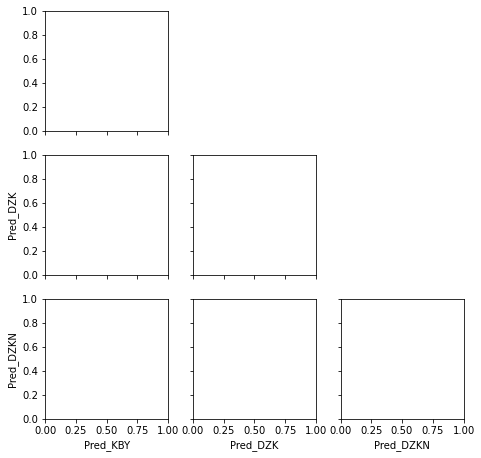

In [20]:
Pred_csv.to_csv(os.path.join(data_path, "Net_Prediction2.csv"))
Pred_csv2 = pd.read_csv(os.path.join(data_path, "Net_Prediction2.csv"))

# Pair-plot
sns.pairplot(Pred_csv2, vars = ["Pred_KBY", "Pred_DZK", "Pred_DZKN"], hue = ["architecture"], corner = True)

NameError: name 'xs' is not defined

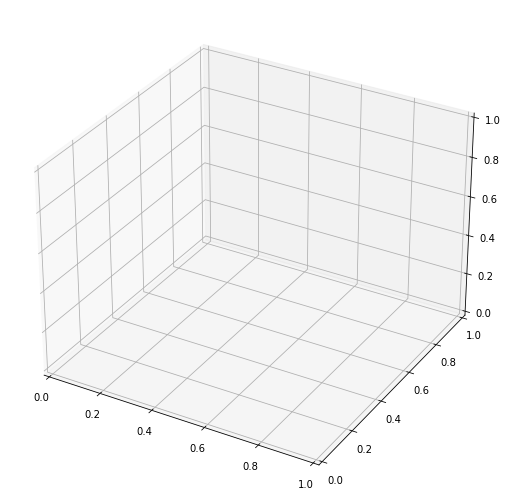

In [19]:
# 3D scatterplot with threshold wirenet
# z = KBY
# x = DZK
# y = DZKN

plt.figure(figsize = (10, 9))

axes = plt.axes(projection = '3d')

KBY = np.concatenate(np.array(Pred_csv["Pred_KBY"].values.tolist()))
DZK = np.concatenate(np.array(Pred_csv["Pred_DZK"].values.tolist()))
DZKN = np.concatenate(np.array(Pred_csv["Pred_DZKN"].values.tolist()))

KBY = KBY.astype(int)
DZK = DZK.astype(int)
DZKN = DZKN.astype(int)

#axes.scatter3D(xs = DZK, ys = DZKN, zs = KBY, s = 50)
cpalette = sns.set_palette(sns.color_palette("gist_ncar", 8))

axes.scatter3D(xs = DZK, ys = DZKN, zs = KBY, s = 50, c = (xs + ys + zs), cmap = cpalette)

axes.set_xlabel('DZK')
axes.set_ylabel('DZKN')
axes.set_zlabel('KBY')
axes.set_xlim((0, 47000000))
axes.set_ylim((0, 12000000))
axes.set_zlim((0, 32000000))

## Make wiregrid threshold
N = 10

X_VAL = np.linspace(int(DZK_px), int(DZK_px), N)
Y_VAL = np.linspace(int(DZKN_px), int(DZKN_px), N)
#Z_VAL = np.linspace(int(KBY_px), int(DZK_px), N)

threshold = np.tan(int(DZK_px), int(DZKN_px), int(KBY_px))


X1, Y1 = np.meshgrid(X_VAL, Y_VAL)
Z1 = X1*1 + Y1*1

#axes.plot_trisurf(X_VAL, Y_VAL, KBY_px, linewidth = 0.2, antialiased = True)

#axes.plot_wireframe(X1, Y1, Z1)

axes.view_init(30, 120, vertical_axis = "z")
plt.show()
